## Exploration of Python Concurrency Methods (Threading, Multiprocessing) to Improve Performance of Image Mean and Standard Deviation Calculations

Here we explore a few Python concurrency methods, namely threading and multiprocessing, to improve the performance of image mean and standard deviation calculations which are inputs to the model.

In [1]:
from torchvision.datasets import VisionDataset, Flickr30k
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
from collections import defaultdict
from PIL import Image
import numpy as np
import nltk
from collections import Counter
import pickle
from tqdm import tqdm
from torchvision import transforms 

import skimage.color
import time

In [2]:
#Load data -- see https://shannon.cs.illinois.edu/DenotationGraph/

flickr_data = Flickr30k('flickr30k-images', 'flickr30k-captions/results_20130124.token')
flickr_data.__len__

<bound method Flickr30k.__len__ of Dataset Flickr30k
    Number of datapoints: 31783
    Root location: flickr30k-images>

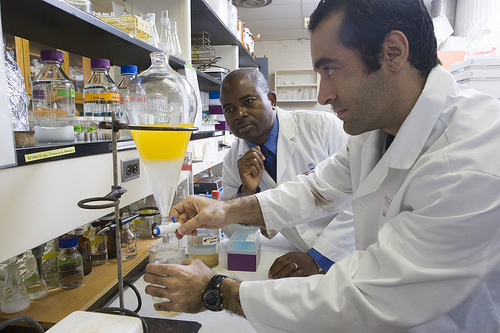

- In a lab full of glassware , a white coat wearing scientist carefully dispenses liquid into another container while another watches attentively .
- Two , white-coated , men in a chemistry lab prepare to pour a solution into vial .
- Two people in lab coats are using scientific materials intently .
- Two male scientists filling a jar full of some kind of liquid .
- Scientists watching liquid flow out of a beaker in a lab .


In [31]:
n = np.random.randint(31_783)
display(flickr_data.__getitem__(n)[0])
for caption in flickr_data.__getitem__(n)[1]:
    print('-',caption)

### Computation of Image RGB means using Multiprocessing and Threading

#### Non-optimized version

In [4]:
start_time = time.time()

filepath = 'flickr30k-images'
r_channel_sum = 0
g_channel_sum = 0
b_channel_sum = 0
count = 0

for filename in os.listdir(filepath):
    if filename[-3:] == 'jpg':
        img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
        r_channel_sum += np.sum(img[:,:,0])
        g_channel_sum += np.sum(img[:,:,1])
        b_channel_sum += np.sum(img[:,:,2])
        count += img.shape[0] * img.shape[1]

print('R channel mean: {}'.format(r_channel_sum/count))
print('G channel mean: {}'.format(g_channel_sum/count))
print('B channel mean: {}'.format(b_channel_sum/count))

end_time = time.time()        
 
print("Time: %ssecs" % (end_time - start_time))

R channel mean: 113.2971859326401
G channel mean: 107.42922106881713
B channel mean: 98.14465223794616
Time: 223.70491218566895secs


#### Multiprocessing with N=4 processes

In [5]:
filepath = 'flickr30k-images'
img_files = [filename for filename in os.listdir(filepath)]
chunks = [(img_files[i:i+500]) for i in range(0, len(img_files), 500)]

def getRGB(chunk):
    r_channel_sum = 0
    g_channel_sum = 0
    b_channel_sum = 0
    count = 0
    for filename in chunk:
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
            r_channel_sum += np.sum(img[:,:,0])
            g_channel_sum += np.sum(img[:,:,1])
            b_channel_sum += np.sum(img[:,:,2])
            count += img.shape[0] * img.shape[1]
    return (r_channel_sum, g_channel_sum, b_channel_sum, count)

from multiprocessing.pool import Pool

start_time = time.time()
with Pool(4) as p:
    res = p.map(getRGB, chunks)
    
results = np.array(res).sum(axis=0)
r,g,b,c = results[0], results[1], results[2], results[3]

end_time = time.time()

print('R channel mean: {}'.format(r/c))
print('G channel mean: {}'.format(g/c))
print('B channel mean: {}'.format(b/c))
print("Time for Multiprocessing with N=4 processes: %ssecs" % (end_time - start_time))

R channel mean: 113.2971859326401
G channel mean: 107.42922106881713
B channel mean: 98.14465223794616
Time for Multiprocessing with N=4 processes: 47.823638916015625secs


#### Threading with N=4 threads

In [6]:
from queue import Queue
from threading import Thread
from threading import Lock

filepath = 'flickr30k-images'
img_files = [filename for filename in os.listdir(filepath)]
chunks = [(img_files[i:i+500]) for i in range(0, len(img_files), 500)]


res = []
def thread_worker(q):
    while True:
        filename = q.get()
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
            r = np.sum(img[:,:,0])
            g = np.sum(img[:,:,1])
            b = np.sum(img[:,:,2])
            count = img.shape[0] * img.shape[1]
            res.append([r,g,b,count])
        q.task_done()

q = Queue()
num_threads = 4
start_time = time.time()
for i in range(num_threads):
    worker = Thread(target=thread_worker, args=(q, ))
    worker.setDaemon(True)
    worker.start()
for filename in img_files:
    q.put(filename)
q.join()
end_time = time.time()

results = np.array(res).sum(axis=0)
r,g,b,c = results[0], results[1], results[2], results[3]
r_mean = r/c
g_mean = g/c
b_mean = b/c

print('R channel mean: {}'.format(r_mean))
print('G channel mean: {}'.format(g_mean))
print('B channel mean: {}'.format(b_mean))
print("Time for Threading: %ssecs" % (end_time - start_time))

R channel mean: 113.2971859326401
G channel mean: 107.42922106881713
B channel mean: 98.14465223794616
Time for Threading: 59.38223195075989secs


In [7]:
print('R channel mean: {:.4f}, normalized: {:.4f}'.format(r_mean, r_mean/255))
print('G channel mean: {:.4f}, normalized: {:.4f}'.format(g_mean, g_mean/255))
print('B channel mean: {:.4f}, normalized: {:.4f}'.format(b_mean, b_mean/255))

R channel mean: 113.2972, normalized: 0.4443
G channel mean: 107.4292, normalized: 0.4213
B channel mean: 98.1447, normalized: 0.3849


### Computation of Image RGB Standard Deviations using Multiprocessing and Threading

#### Non-optimized version

In [8]:
start_time = time.time()
r_channel_sum = 0
g_channel_sum = 0
b_channel_sum = 0
count = 0
filepath = 'flickr30k-images'
for filename in os.listdir(filepath):
    if filename[-3:] == 'jpg':
        img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
        r_channel_sum += np.sum(np.square(img[:,:,0] - r_mean))
        g_channel_sum += np.sum(np.square(img[:,:,1] - g_mean))
        b_channel_sum += np.sum(np.square(img[:,:,2] - b_mean))
        count += img.shape[0] * img.shape[1]
print(np.sqrt(r_channel_sum/count))
print(np.sqrt(g_channel_sum/count))
print(np.sqrt(b_channel_sum/count))     


end_time = time.time()        
 
print("Time: %ssecs" % (end_time - start_time))

72.70319478374367
70.71527787982038
72.8865837762766
Time: 249.21076607704163secs


#### Multiprocessing with N=4 processes

In [9]:
filepath = 'flickr30k-images'
img_files = [filename for filename in os.listdir(filepath)]
chunks = [(img_files[i:i+1000]) for i in range(0, len(img_files), 1000)]

def getRGB(chunk):
    r_channel_sum = 0
    g_channel_sum = 0
    b_channel_sum = 0
    count = 0
    for filename in chunk:
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
            r_channel_sum += np.sum(np.square(img[:,:,0] - r_mean))
            g_channel_sum += np.sum(np.square(img[:,:,1] - g_mean))
            b_channel_sum += np.sum(np.square(img[:,:,2] - b_mean))
            count += img.shape[0] * img.shape[1]
    return (r_channel_sum, g_channel_sum, b_channel_sum, count)

from multiprocessing.pool import Pool

start_time = time.time()
with Pool(4) as p:
    res = p.map(getRGB, chunks)
    
results = np.array(res).sum(axis=0)
r,g,b,c = results[0], results[1], results[2], results[3]

end_time = time.time()

print(np.sqrt(r/c))
print(np.sqrt(g/c))
print(np.sqrt(b/c))

print("Time for Multiprocessing: %ssecs" % (end_time - start_time))

72.70319478374351
70.71527787982005
72.88658377627657
Time for Multiprocessing: 56.37590479850769secs


#### Threading with N=4 threads

In [10]:
from queue import Queue
from threading import Thread
from threading import Lock

filepath = 'flickr30k-images'
img_files = [filename for filename in os.listdir(filepath)]

res = []
def thread_worker(q):
    while True:
        filename = q.get()
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)).convert('RGB'))
            r = np.sum(np.square(img[:,:,0] - r_mean))
            g = np.sum(np.square(img[:,:,1] - g_mean))
            b = np.sum(np.square(img[:,:,2] - b_mean))
            count = img.shape[0] * img.shape[1]
            res.append([r,g,b,count])
        q.task_done()

q = Queue()
num_threads = 4
start_time = time.time()
for i in range(num_threads):
    worker = Thread(target=thread_worker, args=(q, ))
    worker.setDaemon(True)
    worker.start()
for filename in img_files:
    q.put(filename)
q.join()

results = np.array(res).sum(axis=0)
r,g,b,c = results[0], results[1], results[2], results[3]

end_time = time.time()

r_stdev = np.sqrt(r/c)
g_stdev = np.sqrt(g/c)
b_stdev = np.sqrt(b/c)

print(r_stdev)
print(g_stdev)
print(b_stdev)

print("Time for Threading: %ssecs" % (end_time - start_time))

72.70319478374367
70.71527787982038
72.8865837762766
Time for Threading: 72.64487218856812secs


In [11]:
print('R channel standard deviation: {:.4f}, normalized: {:.4f}'.format(r_stdev, r_stdev/255))
print('G channel standard deviation: {:.4f}, normalized: {:.4f}'.format(g_stdev, g_stdev/255))
print('B channel standard deviation: {:.4f}, normalized: {:.4f}'.format(b_stdev, b_stdev/255))

R channel standard deviation: 72.7032, normalized: 0.2851
G channel standard deviation: 70.7153, normalized: 0.2773
B channel standard deviation: 72.8866, normalized: 0.2858


**It appears that multithreading with 4 processes was the most efficient method, taking 104.2 seconds in total to compute the R/G/B means and standard deviations across all 31,783 images in the Flickr30K dataset. Notably, this is just a fraction (about 22%) of the time taken without using concurrency to optimize the code, which totaled 472.9 seconds.**